In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
from scipy.stats.mstats import gmean
import scipy.optimize as opt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import numpy as np

In [2]:
data = pd.read_pickle('LuxSE.pkl')
mean = data.groupby(['AHL','IPTG'])['FITC-A'].apply(gmean).reset_index()
mean = pd.concat([mean,mean.apply(np.log10,axis=0,result_type='broadcast').iloc[:,0]],axis=1)
mean.columns= ['AHL','IPTG','FITC-A','logAHL']
mean = mean.astype({'logAHL': 'int32'})
# normalized
norm = mean.copy()
norm['FITC-A']=norm['FITC-A']/norm['FITC-A'].max()*100
piv = norm.pivot_table(index='IPTG', columns='logAHL', values='FITC-A')
R =[]
for i in mean.IPTG.unique():
    tmp = mean[mean.IPTG ==i]['FITC-A'].max()/mean[mean.IPTG ==i]['FITC-A'].min()
    R.append([i,tmp])
R = pd.DataFrame(R,columns=['IPTG','Induction Ratio'])

In [3]:
piv

logAHL,-12,-10,-8,-6,-4
IPTG,,,,,
0.0000,15.242206,15.229844,17.010977,45.526578,NaN
0.0002,17.994845,15.887340,41.282206,92.761904,100.000000
0.0010,16.970846,15.303982,44.030489,84.404613,82.049836


In [4]:
mean

,AHL,IPTG,FITC-A,logAHL
0,1.000000e-12,0.0000,3195.695276,-12
1,1.000000e-12,0.0002,3772.816271,-12
2,1.000000e-12,0.0010,3558.123646,-12
3,1.000000e-10,0.0000,3193.103654,-10
4,1.000000e-10,0.0002,3330.954809,-10
5,1.000000e-10,0.0010,3208.647370,-10
6,1.000000e-08,0.0000,3566.537591,-8
7,1.000000e-08,0.0002,8655.266508,-8
8,1.000000e-08,0.0010,9231.474032,-8
9,1.000000e-06,0.0000,9545.145612,-6


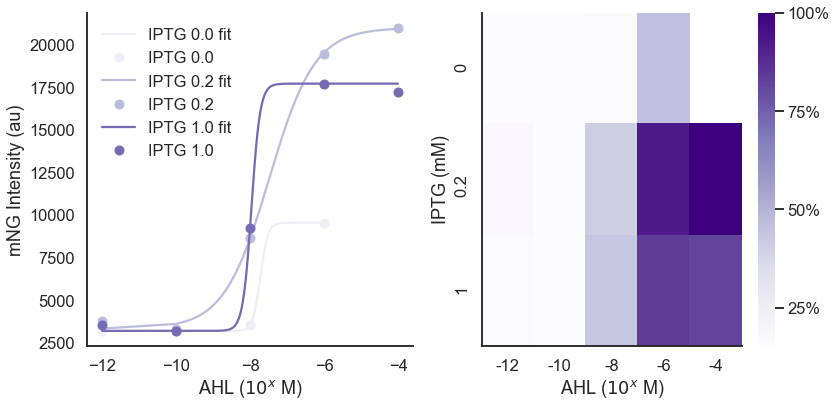

In [5]:
colors = ['#efedf5','#bcbddc','#756bb1']
sns.set_context('talk')
sns.set_style('white')
f, axes = plt.subplots(ncols=2,figsize=(12,6))

# fit Hill function
lines = []  
fits = pd.DataFrame(columns=['AHL','FITC-A','IPTG'])
for i,iptg in enumerate(mean.IPTG.unique()):
    tmp = mean[mean.IPTG==iptg]
    def func(x, a, b):
        return (tmp['FITC-A'].max() -tmp['FITC-A'].min()) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + tmp['FITC-A'].min()
    (a_, b_), _ = opt.curve_fit(func, tmp.AHL, tmp['FITC-A'],p0=[1,1e-9],maxfev=10000000)
    n = 1e6
    x = np.linspace(tmp.AHL.min(), tmp.AHL.max(), int(n))
    y_fit = func(x, a_, b_)
    fits=fits.append(pd.DataFrame(np.concatenate([[x], [y_fit],[np.ones(len(x))*iptg]]).T,columns=['AHL','FITC-A','IPTG']),ignore_index=True)
    lines += axes[0].plot(np.log10(x), y_fit, '-',color = colors[i],label='IPTG {:.1f} fit'.format(iptg*1e3))
    lines += axes[0].plot(np.log10(tmp.AHL.values), tmp['FITC-A'].values, 'o',color = colors[i],label='IPTG {:.1f}'.format(iptg*1e3))

labels = [l.get_label() for l in lines]
g = sns.heatmap(piv, cmap='Purples',ax=axes[1])
cbar = g.collections[0].colorbar
cbar.set_ticks([0, 25, 50, 75,100])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
axes[0].set_xlabel(r'AHL ($10^x$ M)')
axes[0].set_ylabel(r'mNG Intensity (au)')

axes[0].legend(labels,frameon=False)
axes[1].set_xlabel(r'AHL ($10^x$ M)')
axes[1].set_ylabel(r'IPTG (mM)')
axes[1].set_yticklabels(['0','0.2','1'])
#f.tight_layout()
#sns.barplot(x='IPTG',y='Induction Ratio',data=R,palette='Blues',ax=axes[2])
sns.despine()
#axes[1].xaxis.set_major_formatter(ticker.LogFormatter())
#axes[1].yaxis.set_major_formatter(ticker.ScalarFormatter())
#axes[1].ticklabel_format(axis='both',style='scientific')
f.tight_layout()
f.savefig('TraSE.png',dpi=300)

<AxesSubplot:xlabel='AHL', ylabel='FITC-A'>

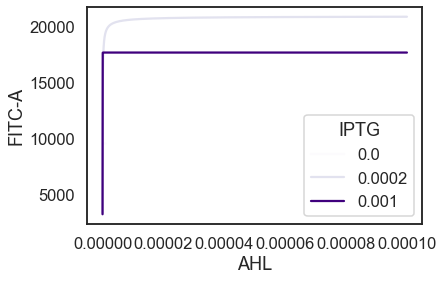

In [6]:
sns.lineplot(x='AHL',y='FITC-A',hue='IPTG',markers='',data=fits,palette='Purples')

IPTG=0.0


C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


IPTG=0.0002


C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


IPTG=0.001


C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


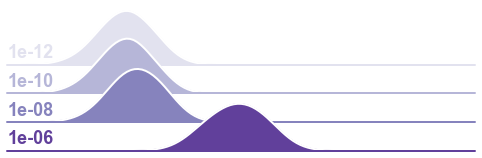

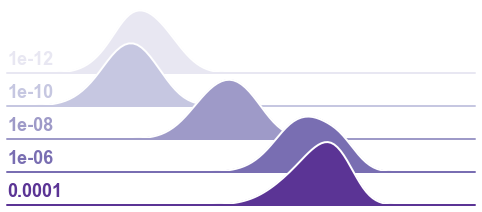

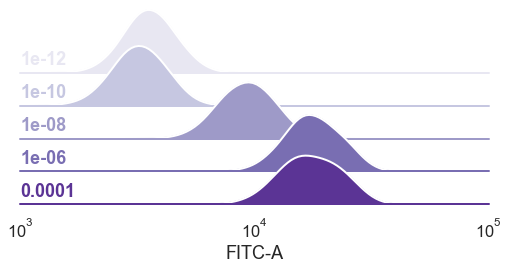

In [7]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
sns.set_context('talk')
for I in data.IPTG.unique():
    tmpdf = data[data.IPTG==I][['AHL','FITC-A']]
    print('IPTG=' +str(I))
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(tmpdf, row="AHL", hue="AHL", aspect=10, height=.75, palette='Purples')#
    #g.set(xlim=(0, 20000))
    # Draw the densities in a few steps
    g.map(sns.kdeplot, "FITC-A", clip_on=True, shade=True, alpha=1, lw=1,log_scale=True,bw_adjust=3)
    g.map(sns.kdeplot, "FITC-A", clip_on=True, color="w", lw=2,log_scale=True,bw_adjust=3)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
        #ax.set_xlim(1e2,2e5)
    g.set(xlim=(1e3,1e5))

    if I ==0.001:
        g.map(label, "FITC-A")
    else:
        g.map(label, "FITC-A")
        for ax in g.axes.flat:
            ax.set_axis_off()
        g.set(xticks=[])

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.5)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    #plt.show()
    g.savefig('Ridge_Tra_IPTG {:.1e}.pdf'.format(I))


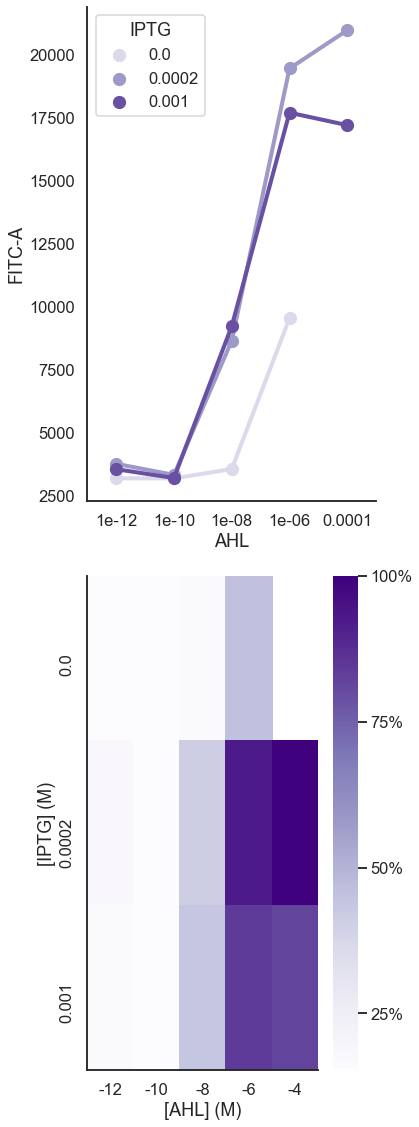

In [8]:
sns.set_context('talk')
sns.set_style('white')
f, axes = plt.subplots(nrows=2,figsize=(6,16))
sns.pointplot(x='AHL',y='FITC-A',hue='IPTG',estimator=gmean,data=data,palette='Purples',ax=axes[0])
g = sns.heatmap(piv, cmap='Purples',ax=axes[1])
cbar = g.collections[0].colorbar
cbar.set_ticks([0, 25, 50, 75,100])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
axes[1].set_xlabel(r'[AHL] (M)')
axes[1].set_ylabel(r'[IPTG] (M)')
#f.tight_layout()
#sns.barplot(x='IPTG',y='Induction Ratio',data=R,palette='Blues',ax=axes[2])
sns.despine()
#axes[1].xaxis.set_major_formatter(ticker.LogFormatter())
#axes[1].yaxis.set_major_formatter(ticker.ScalarFormatter())
#axes[1].ticklabel_format(axis='both',style='scientific')
f.tight_layout()
#f.savefig('LUXSE_Tall.png',dpi=300)